In [69]:
import gzip
import csv
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib
import libpysal
import segregation
from segregation.local import MultiLocationQuotient, MultiLocalDiversity, MultiLocalEntropy, MultiLocalSimpsonInteraction, MultiLocalSimpsonConcentration, LocalRelativeCentralization

%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
#read lodes data
lehd_df = pd.read_csv('data\lodes\ca_wac_S000_JT00_2017.csv.gz',compression='gzip',header=0,sep=',',quotechar='"',error_bad_lines=False)
#convert w_geocode to string to make it easier to check
lehd_df['w_geocode'] = lehd_df['w_geocode'].astype(str)
# check if beginning of string matches SD county fips code
lehd_df = lehd_df[lehd_df['w_geocode'].str.match('6073')]
#add leading 0 to make consistent with block data(below)
#SDlehd_df.iloc[] = '0' + SDlehd_df.loc['w_geocode']
lehd_df['w_geocode'] = '0' + lehd_df['w_geocode']

In [3]:
lehd_df

,w_geocode,C000,CA01,CA02,CA03,CE01,CE02,CE03,CNS01,CNS02,CNS03,CNS04,CNS05,CNS06,CNS07,CNS08,CNS09,CNS10,CNS11,CNS12,CNS13,CNS14,CNS15,CNS16,CNS17,CNS18,CNS19,CNS20,CR01,CR02,CR03,CR04,CR05,CR07,CT01,CT02,CD01,CD02,CD03,CD04,CS01,CS02,CFA01,CFA02,CFA03,CFA04,CFA05,CFS01,CFS02,CFS03,CFS04,CFS05,createdate
174510,060730001001000,9,1,3,5,1,0,8,0,0,0,0,0,0,0,0,0,0,4,2,0,0,2,0,0,1,0,0,7,0,0,2,0,0,8,1,0,1,4,3,6,3,0,0,0,0,0,0,0,0,0,0,20190825
174511,060730001001003,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,20190825
174512,060730001001004,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,20190825
174513,060730001001010,4,0,0,4,0,2,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,4,0,0,0,0,0,2,2,2,0,1,1,2,2,0,0,0,0,0,0,0,0,0,0,20190825
174514,060730001001011,2,0,1,1,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,0,20190825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192210,060730221003012,8,0,5,3,3,2,3,0,0,0,0,0,0,0,0,0,0,1,3,0,0,0,4,0,0,0,0,6,0,0,2,0,0,4,4,1,2,4,1,0,8,0,0,0,0,0,0,0,0,0,0,20190825
192211,060730221003013,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,20190825
192212,060730221003014,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,20190825
192213,060730221003015,44,2,31,11,9,11,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,0,0,0,0,0,39,0,1,3,1,0,35,9,3,4,16,19,11,33,0,0,0,0,0,0,0,0,0,0,20190825


In [4]:
# Lets get the shp data ready to be linked to the LODES data
sd_blocks = gpd.read_file('data\\blocks\\sd\\tl_2010_06073_tabblock10.shp')
sd_blocks

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,06,073,016902,1159,060730169021159,Block 1159,G5040,R,None,None,S,155475,0,+32.9028933,-116.9070116,"POLYGON ((-116.90485 32.90222, -116.90486 32.9..."
1,06,073,016902,1012,060730169021012,Block 1012,G5040,R,None,None,S,682684,0,+32.9608914,-116.8167736,"POLYGON ((-116.81117 32.96339, -116.81118 32.9..."
2,06,073,013310,2013,060730133102013,Block 2013,G5040,U,78661,U,S,7308,0,+32.6363816,-116.9703056,"POLYGON ((-116.97002 32.63583, -116.97013 32.6..."
3,06,073,016701,2009,060730167012009,Block 2009,G5040,U,78661,U,S,22568,0,+32.8435707,-116.9558789,"POLYGON ((-116.95483 32.84252, -116.95510 32.8..."
4,06,073,016902,1186,060730169021186,Block 1186,G5040,R,None,None,S,439184,0,+32.9292921,-116.8574745,"POLYGON ((-116.86183 32.93071, -116.86167 32.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43410,06,073,019002,1040,060730190021040,Block 1040,G5040,R,None,None,S,47466,0,+33.4151060,-117.1569694,"POLYGON ((-117.15646 33.41382, -117.15690 33.4..."
43411,06,073,019002,1108,060730190021108,Block 1108,G5040,R,None,None,S,25314,0,+33.3877592,-117.1330485,"POLYGON ((-117.13181 33.38781, -117.13185 33.3..."
43412,06,073,019002,1015,060730190021015,Block 1015,G5040,R,None,None,S,1562459,0,+33.4095912,-117.1339117,"POLYGON ((-117.13358 33.40617, -117.13361 33.4..."
43413,06,073,018803,2017,060730188032017,Block 2017,G5040,R,None,None,S,3705,0,+33.2776869,-117.1874068,"POLYGON ((-117.18726 33.27850, -117.18726 33.2..."


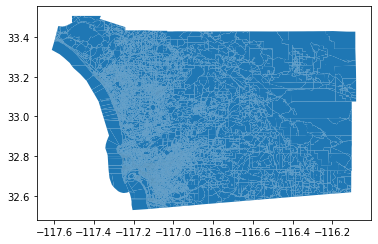

In [5]:
sd_blocks.plot()

In [88]:
# rename column for join
lehd_df.rename(columns={'w_geocode': 'GEOID10'}, inplace=True)
# merge geodataframe and dataframe on common variable
SDlehd_blocks = sd_blocks.merge(lehd_df, how='left', on='GEOID10')

In [89]:
#Get rid of many unneeded columns/rows
SDlehd_blocks.drop(['INTPTLON10','INTPTLAT10','COUNTYFP10','STATEFP10','NAME10','TRACTCE10','BLOCKCE10','MTFCC10','FUNCSTAT10','UR10','AWATER10','UACE10','UATYP10','createdate'], axis=1, inplace=True)
SDlehd_blocks.fillna(0,inplace=True)
#Remove any blocks where there is no land area, no jobs there so why would we care about them?
SDlehd_blocks = SDlehd_blocks[SDlehd_blocks.ALAND10 != 0]
SDlehd_blocks

,GEOID10,ALAND10,geometry,C000,CA01,CA02,CA03,CE01,CE02,CE03,CNS01,CNS02,CNS03,CNS04,CNS05,CNS06,CNS07,CNS08,CNS09,CNS10,CNS11,CNS12,CNS13,CNS14,CNS15,CNS16,CNS17,CNS18,CNS19,CNS20,CR01,CR02,CR03,CR04,CR05,CR07,CT01,CT02,CD01,CD02,CD03,CD04,CS01,CS02,CFA01,CFA02,CFA03,CFA04,CFA05,CFS01,CFS02,CFS03,CFS04,CFS05
0,060730169021159,155475,"POLYGON ((-116.90485 32.90222, -116.90486 32.9...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,060730169021012,682684,"POLYGON ((-116.81117 32.96339, -116.81118 32.9...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,060730133102013,7308,"POLYGON ((-116.97002 32.63583, -116.97013 32.6...",2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,060730167012009,22568,"POLYGON ((-116.95483 32.84252, -116.95510 32.8...",2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,060730169021186,439184,"POLYGON ((-116.86183 32.93071, -116.86167 32.9...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43410,060730190021040,47466,"POLYGON ((-117.15646 33.41382, -117.15690 33.4...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43411,060730190021108,25314,"POLYGON ((-117.13181 33.38781, -117.13185 33.3...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43412,060730190021015,1562459,"POLYGON ((-117.13358 33.40617, -117.13361 33.4...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43413,060730188032017,3705,"POLYGON ((-117.18726 33.27850, -117.18726 33.2...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


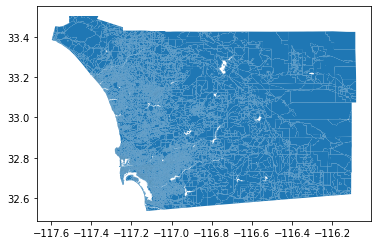

In [90]:
SDlehd_blocks.plot()

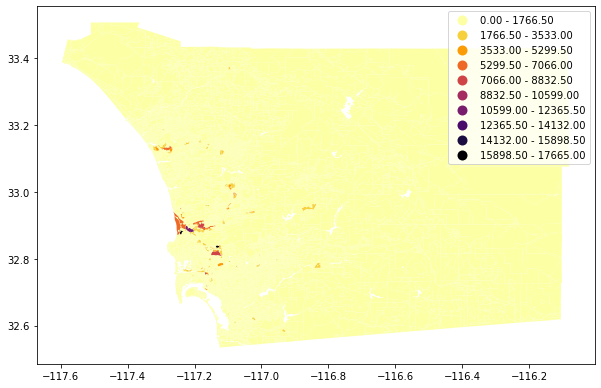

In [109]:
#Lets do some fancier plotting
#alljobs = SDlehd_blocks['C000']
#alljobsmap = mapclassify.FisherJenks(alljobs, k=5)
#alljobsmap

#C000Q10 = mapclassify.EqualInterval(SDlehd_blocks['C000'], k=10)
#C000Q10
#SDlehd_blocks.assign(C000Q10=C000Q10.yb).plot(column='C000Q10', cmap='inferno_r',legend = True,k=10)

SDlehd_blocks.plot(column='C000', cmap='inferno_r', k=10, scheme='equalinterval', figsize = (10,10), legend=True)

In [131]:
#create list of jobs if want to calculate measure for different job types 
df_columns = SDlehd_blocks.columns.tolist()
jobs_list = df_columns[4:54]
jobs_list

['CA01',
 'CA02',
 'CA03',
 'CE01',
 'CE02',
 'CE03',
 'CNS01',
 'CNS02',
 'CNS03',
 'CNS04',
 'CNS05',
 'CNS06',
 'CNS07',
 'CNS08',
 'CNS09',
 'CNS10',
 'CNS11',
 'CNS12',
 'CNS13',
 'CNS14',
 'CNS15',
 'CNS16',
 'CNS17',
 'CNS18',
 'CNS19',
 'CNS20',
 'CR01',
 'CR02',
 'CR03',
 'CR04',
 'CR05',
 'CR07',
 'CT01',
 'CT02',
 'CD01',
 'CD02',
 'CD03',
 'CD04',
 'CS01',
 'CS02',
 'CFA01',
 'CFA02',
 'CFA03',
 'CFA04',
 'CFA05',
 'CFS01',
 'CFS02',
 'CFS03',
 'CFS04',
 'CFS05']

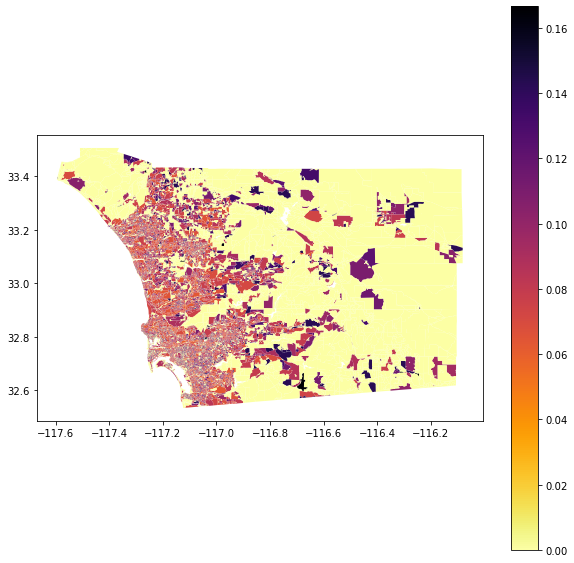

In [133]:
SimpsonIndex = MultiLocalSimpsonConcentration(SDlehd_blocks, jobs_list)
SDlehd_blocks['Local_Simpson_Concentration'] = SimpsonIndex.statistics
SDlehd_blocks.plot(column='Local_Simpson_Concentration', cmap='inferno_r', figsize = (10,10), legend=True)

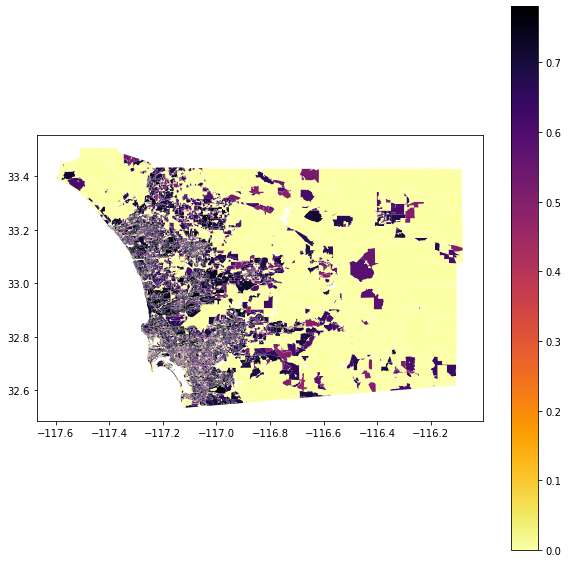

In [134]:
LocalEntropyIndex = MultiLocalEntropy(SDlehd_blocks, jobs_list)
SDlehd_blocks['Local_Entropy'] = LocalEntropyIndex.statistics
SDlehd_blocks.plot(column='Local_Entropy', cmap='inferno_r', figsize = (10,10), legend=True)

In [ ]:
LQIndex = MultiLocationQuotient(input_df, jobs_list)
LQIndex.statistics
for i in range(len(groups_list)):
    input_df['LQ_' + groups_list[i]] = index.statistics[:,i]
